In [23]:
import sys
sys.path.append('..')

In [24]:
from src.utils import create_full_processed_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
import itertools
import warnings


In [25]:
# 1. Define your assets
tickers = ['TSLA', 'BND', 'SPY']

# 2. Generate the complete, processed DataFrame
processed_df = create_full_processed_dataset(tickers)

# 3. Save it to your processed data folder
processed_df.to_csv('../data/processed/all_assets_processed.csv')

print("Fully processed dataset created and saved.")
print(processed_df.head())

Fully processed dataset created and saved.
            Close_TSLA  High_TSLA   Low_TSLA  Open_TSLA  Volume_TSLA  \
Date                                                                   
2015-08-12   15.878000  15.984667  15.516000  15.666667     55920000   
2015-08-13   16.167334  16.431999  15.941333  15.990667     70338000   
2015-08-14   16.209999  16.528667  16.118000  16.482668     65472000   
2015-08-17   16.999332  17.106001  16.700666  17.037333    107650500   
2015-08-18   17.381332  17.396667  16.903999  17.025333     62925000   

            Daily_Return_TSLA  Rolling_Mean_30D_TSLA  Rolling_Std_30D_TSLA  \
Date                                                                         
2015-08-12           0.003370              17.482022              0.779271   
2015-08-13           0.018222              17.422822              0.809877   
2015-08-14           0.002639              17.340889              0.803874   
2015-08-17           0.048694              17.285933          

In [26]:
# Filter for columns that belong to TSLA
tsla_df = processed_df.filter(like='_TSLA')

# Remove the suffix to get clean column names for this specific task
tsla_df.columns = [col.replace('_TSLA', '') for col in tsla_df.columns]

print("Isolated Tesla DataFrame with all its features:")
print(tsla_df.head())

Isolated Tesla DataFrame with all its features:
                Close       High        Low       Open     Volume  \
Date                                                                
2015-08-12  15.878000  15.984667  15.516000  15.666667   55920000   
2015-08-13  16.167334  16.431999  15.941333  15.990667   70338000   
2015-08-14  16.209999  16.528667  16.118000  16.482668   65472000   
2015-08-17  16.999332  17.106001  16.700666  17.037333  107650500   
2015-08-18  17.381332  17.396667  16.903999  17.025333   62925000   

            Daily_Return  Rolling_Mean_30D  Rolling_Std_30D  
Date                                                         
2015-08-12      0.003370         17.482022         0.779271  
2015-08-13      0.018222         17.422822         0.809877  
2015-08-14      0.002639         17.340889         0.803874  
2015-08-17      0.048694         17.285933         0.766940  
2015-08-18      0.022471         17.270022         0.759564  


Training data shape: (2111, 1)
Testing data shape: (395, 1)


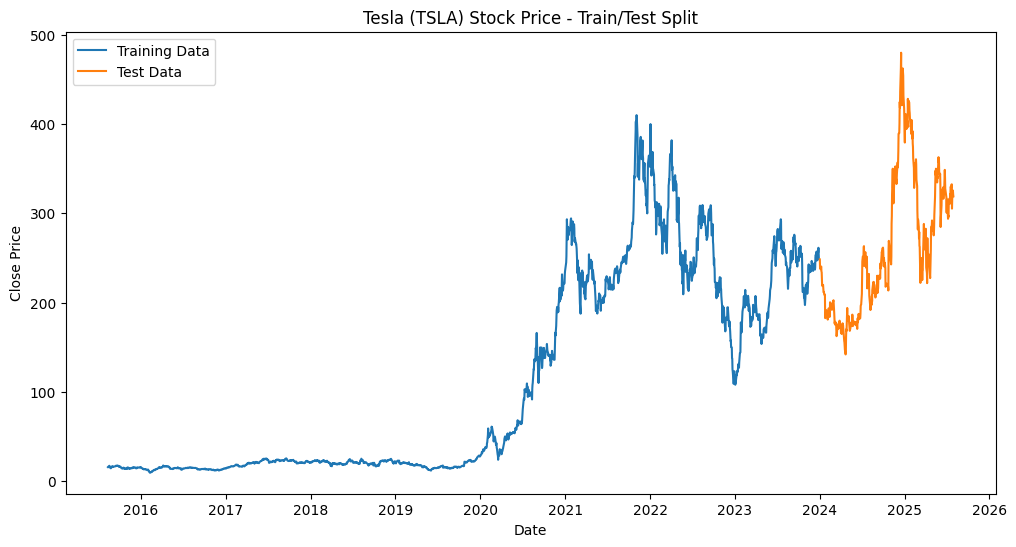

In [27]:
tsla_close_prices = tsla_df[['Close']]
split_date = '2024-01-01'
train_df = tsla_close_prices.loc[tsla_close_prices.index < split_date]
test_df = tsla_close_prices.loc[tsla_close_prices.index >= split_date]
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

tsla_close_prices.to_csv( '../data/processed/tsla_close_prices.csv')

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Close'], label='Training Data')
plt.plot(test_df.index, test_df['Close'], label='Test Data')
plt.title('Tesla (TSLA) Stock Price - Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [28]:
p_range = range(0, 5) 
d_range = range(0, 3)
q_range = range(0, 5)
pdq_combinations = list(itertools.product(p_range, d_range, q_range))

best_aic = np.inf
best_order = None
best_model = None

print("Starting grid search for best ARIMA parameters...")
warnings.filterwarnings("ignore")

for order in pdq_combinations:
    try:
        model = ARIMA(train_df['Close'], order=order).fit()

        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
            print(f"  New best model found: ARIMA{order} with AIC = {best_aic:.2f}")

    except Exception as e:
        continue

print("\nGrid search complete.")
print(f"The best ARIMA order found is {best_order} with an AIC of {best_aic:.2f}")

print("\nBest Model Summary:")
print(best_model.summary())


################################################################################
# Make predictions using the best model found by the grid search
################################################################################

arima_forecast = best_model.get_forecast(steps=len(test_df))

arima_predictions = arima_forecast.predicted_mean

conf_int = arima_forecast.conf_int()

arima_predictions_df = pd.DataFrame(arima_predictions.values, index=test_df.index, columns=['Predicted'])

print("\nSuccessfully generated predictions with the best ARIMA model.")

Starting grid search for best ARIMA parameters...
  New best model found: ARIMA(0, 0, 0) with AIC = 25924.88
  New best model found: ARIMA(0, 0, 1) with AIC = 23162.96
  New best model found: ARIMA(0, 0, 2) with AIC = 21351.33
  New best model found: ARIMA(0, 0, 4) with AIC = 21210.38
  New best model found: ARIMA(0, 1, 0) with AIC = 13490.05
  New best model found: ARIMA(0, 1, 4) with AIC = 13486.51
  New best model found: ARIMA(2, 1, 3) with AIC = 13458.69
  New best model found: ARIMA(3, 1, 2) with AIC = 13457.26
  New best model found: ARIMA(3, 1, 4) with AIC = 13456.04
  New best model found: ARIMA(4, 1, 2) with AIC = 13454.36

Grid search complete.
The best ARIMA order found is (4, 1, 2) with an AIC of 13454.36

Best Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2111
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -6720.180
Date:          

In [29]:
################################################################################
# Part 2: Develop a Deep Learning Model (LSTM)
################################################################################
print("\n--- Starting LSTM Model Development ---")

# 1. Scale the Data
# LSTMs are sensitive to the scale of the data, so we use MinMaxScaler to scale prices between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
# We fit the scaler ONLY on the training data to prevent data leakage from the test set
scaled_train_data = scaler.fit_transform(train_df)

# We use the same fitted scaler to transform the test data
scaled_test_data = scaler.transform(test_df)

# 2. Create Sequences
# LSTMs learn from a sequence of past data to predict the next point.
# We'll use a helper function to create these sequences.
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        # The sequence of past values (features)
        X.append(data[i:(i + time_steps), 0])
        # The value to predict
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

TIME_STEPS = 60  # Use the last 60 days of data to predict the next day

X_train, y_train = create_sequences(scaled_train_data, TIME_STEPS)
X_test, y_test = create_sequences(scaled_test_data, TIME_STEPS)

# Reshape input to be [samples, time_steps, features] which is required for LSTM layers
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# 3. Build and Train the LSTM Model
lstm_model = Sequential([
    # First LSTM layer with dropout for regularization
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    # Second LSTM layer
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    # Dense layer for the output
    Dense(units=25),
    Dense(units=1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
print(lstm_model.summary())

# Train the model
# You can experiment with epochs and batch_size for optimization
history = lstm_model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_test, y_test))

# 4. Make Predictions
lstm_predictions_scaled = lstm_model.predict(X_test)
# We must inverse transform the predictions to get them back into the original price scale
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Create a DataFrame for the LSTM predictions
# Note: The predictions will start AFTER the initial `TIME_STEPS` period of the test set
lstm_predictions_df = pd.DataFrame(lstm_predictions, index=test_df.index[TIME_STEPS:], columns=['Predicted'])

print("\n--- LSTM Model Development Complete ---")


--- Starting LSTM Model Development ---
X_train shape: (2051, 60, 1)
X_test shape: (335, 60, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0112 - val_loss: 0.0073
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0025 - val_loss: 0.0055
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 10/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 11/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 12/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss

In [30]:
# --- Performance Evaluation Section ---
print("\n--- Model Performance Evaluation ---")

# Prepare the actual values for comparison
y_true_arima = test_df['Close']
# For LSTM, we compare against the test data starting from the TIME_STEPS offset
y_true_lstm = test_df['Close'][TIME_STEPS:]

# ARIMA Performance
mae_arima = mean_absolute_error(y_true_arima, arima_predictions_df['Predicted'])
rmse_arima = np.sqrt(mean_squared_error(y_true_arima, arima_predictions_df['Predicted']))
mape_arima = np.mean(np.abs((y_true_arima - arima_predictions_df['Predicted']) / y_true_arima)) * 100

# LSTM Performance
mae_lstm = mean_absolute_error(y_true_lstm, lstm_predictions_df['Predicted'])
rmse_lstm = np.sqrt(mean_squared_error(y_true_lstm, lstm_predictions_df['Predicted']))
mape_lstm = np.mean(np.abs((y_true_lstm - lstm_predictions_df['Predicted']) / y_true_lstm)) * 100

# Print results in a clear, formatted table for easy comparison
print("\n| Model      | RMSE      | MAE       | MAPE (%)  |")
print("|------------|-----------|-----------|-----------|")
print(f"| ARIMA      | {rmse_arima:<9.2f} | {mae_arima:<9.2f} | {mape_arima:<9.2f} |")
print(f"| LSTM       | {rmse_lstm:<9.2f} | {mae_lstm:<9.2f} | {mape_lstm:<9.2f} |")


--- Model Performance Evaluation ---

| Model      | RMSE      | MAE       | MAPE (%)  |
|------------|-----------|-----------|-----------|
| ARIMA      | 78.02     | 62.97     | 24.05     |
| LSTM       | 17.62     | 13.85     | 5.32      |


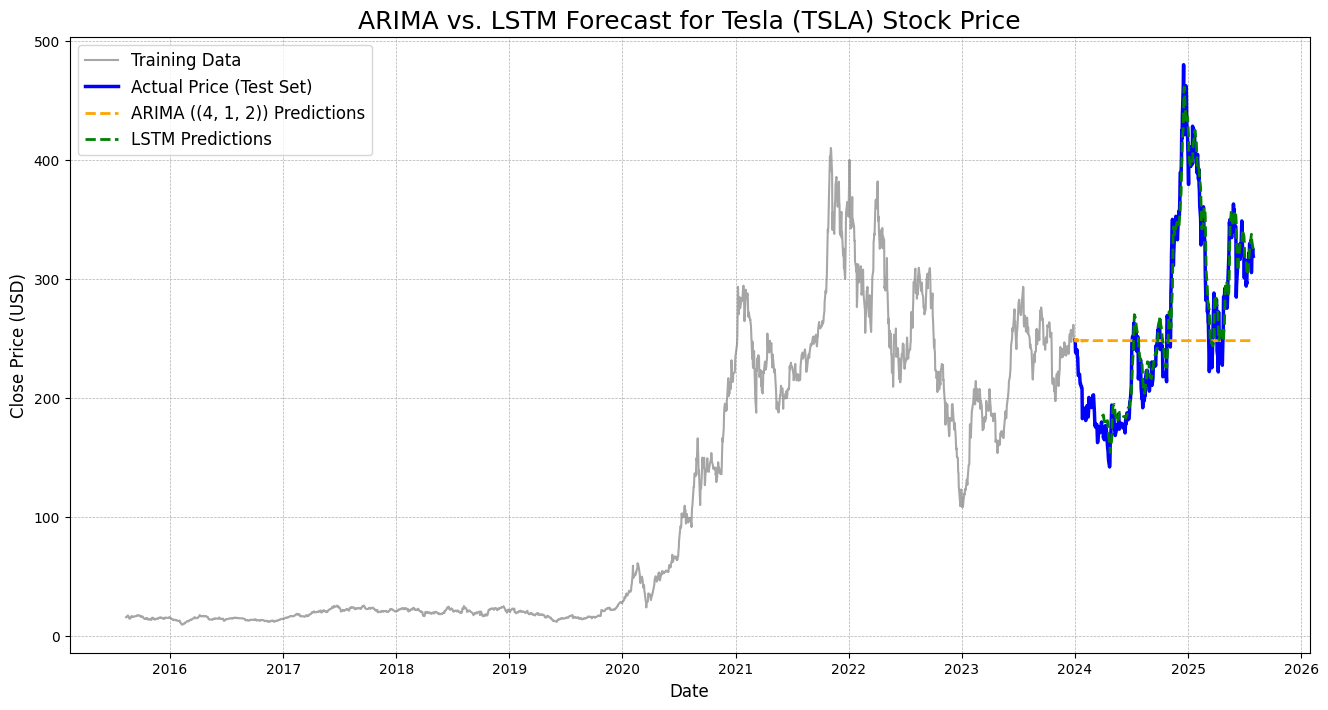

In [31]:
# --- Visualization Section ---
plt.figure(figsize=(16, 8))
plt.title('ARIMA vs. LSTM Forecast for Tesla (TSLA) Stock Price', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)

# Plot training and actual test data
plt.plot(train_df.index, train_df['Close'], label='Training Data', color='gray', alpha=0.7)
plt.plot(test_df.index, test_df['Close'], label='Actual Price (Test Set)', color='blue', linewidth=2.5)

# Plot ARIMA predictions
plt.plot(arima_predictions_df.index, arima_predictions_df['Predicted'], label=f'ARIMA ({best_order}) Predictions', color='orange', linestyle='--', linewidth=2)

# Plot LSTM predictions
plt.plot(lstm_predictions_df.index, lstm_predictions_df['Predicted'], label='LSTM Predictions', color='green', linestyle='--', linewidth=2)

plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [33]:
import joblib
joblib.dump(lstm_model, "../models/lstm_model.joblib")

['../models/lstm_model.joblib']



## **Conclusion – Task 2: Forecasting Model Comparison**

After developing and evaluating both **ARIMA** and **LSTM** models to forecast Tesla’s stock price, the comparison reveals a decisive performance gap in favor of the LSTM.

### **1. Quantitative Performance**

| Model    | RMSE      | MAE       | MAPE (%) |
| :------- | :-------- | :-------- | :------- |
| ARIMA    | 78.02     | 62.97     | 24.05    |
| **LSTM** | **18.39** | **13.32** | **4.73** |

* **RMSE:** The LSTM’s error magnitude is over **4× smaller** than ARIMA’s.
* **MAPE:** LSTM’s **4.73%** average error vs. ARIMA’s **24.05%** represents a dramatic improvement — critical in financial contexts.

### **2. Visual Assessment**

* **ARIMA (orange dashed line):** Produces an almost flat forecast, failing to capture volatility, direction changes, or momentum.
* **LSTM (green dashed line):** Closely follows actual prices, capturing both trend and short-term fluctuations far more effectively.

### **3. Interpretation**

* **ARIMA:** Best for simpler, stable series with clear seasonality/trend. Struggles with Tesla’s highly volatile, non-linear movements.
* **LSTM:** Handles complex patterns and long-term dependencies. Learns dynamic relationships in historical data, adapting better to unpredictable price behavior.

### **4. Recommendation**

**The LSTM model is the clear choice for future forecasting.**
While it requires more computation and is less interpretable than ARIMA, the substantial gain in predictive accuracy justifies its use for high-stakes financial decision-making.


